In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/SejongMusic


In [3]:
import argparse
import datetime
import copy
from pathlib import Path
from omegaconf import OmegaConf
from fractions import Fraction
from tqdm.auto import tqdm

import torch
from music21 import converter, stream, note as m21_note 

from sejong_music import model_zoo, jg_code, inference
from sejong_music.yeominrak_processing import OrchestraScoreSeq, ShiftedAlignedScore, Tokenizer
from sejong_music.model_zoo import JeongganTransSeq2seq
from sejong_music.decode import MidiDecoder, OrchestraDecoder
from sejong_music.inference_utils import prepare_input_for_next_part, get_measure_specific_output, fix_measure_idx, fill_in_source, get_measure_shifted_output, recover_beat, round_number
from sejong_music.inference import JGInferencer
from sejong_music.jg_to_staff_converter import JGToStaffConverter
from sejong_music.jg_code import JeongganDataset, JeongganTokenizer
from sejong_music.full_inference import Generator

In [10]:
config = OmegaConf.load('yamls/gen_settings/jg_cph.yaml')

gen = Generator(config)
score_fn = 'gen_results/CHP_scoreCPH_from_1_0308-1209.musicxml'
gen.model.to('cuda:1')
gen.inference_from_xml(score_fn, ['geomungo', 'gayageum', 'ajaeng', 'haegeum', 'piri', 'daegeum'])

None of the note[1] is matched while note[2]==0: ('하배임', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배황', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배중', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('하배태', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배태', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배황', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배중', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배태', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배황', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배중', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배임', 0.0, 0.0)
['geomungo']


100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


['gayageum', 'geomungo']


100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


['ajaeng', 'gayageum', 'geomungo']


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


['haegeum', 'ajaeng', 'gayageum', 'geomungo']


100%|██████████| 7/7 [00:10<00:00,  1.57s/it]


['piri', 'haegeum', 'ajaeng', 'gayageum', 'geomungo']


100%|██████████| 7/7 [00:14<00:00,  2.04s/it]


':0 청황 | :8 니레나 | :0 임 노니로 | :8 남 니레 | :2 청황 :6 리 :7 청태 :9 청황 | :2 남 :6 니나* :8 느나 | :0 청태 니레 | | :2 청임 :8 같은음표 니레 | :2 청남 :6 노 :8 청중 | :0 청황 | | :2 같은음표 니나 :8 청태 니레 | :2 같은음표 니레 :6 니나* :8 청황 | :2 청황 :8 청태 나니나 | :2 청황 :6 리 :7 청태 :9 청황 | :0 청황 | | :0 남 흘림표 | :2 임 :8 남 니레 \n :0 청황 | :8 니레나 | :2 중 :8 임 나니나 | :2 남 :6 노 :8 중 | :0 중 흘림표 | :2 태 :6 니나* :8 황 | :0 중 | | :2 남 :9 노 노니로 | :2 임 :8 남 니레 | :0 중 | | :2 청황 :8 니레나 | :2 남 :6 노 노니로 :8 남 | :2 청황 :8 청태 나니나 | :2 중 :6 니 :8 태 | :0 황 | | :2 남 :8 같은음표 나니나 | :2 임 :8 남 니레 \n :0 임 | :8 남 니레 | :0 임 | :6 리 :7 남 :9 임 | :0 청태 | :6 노 :8 청중 | :2 청황 :8 청태 니레 | :2 청황 :6 니 :8 남 | :2 청태 :8 같은음표 나니나 | :2 남 :6 니나* :8 임 | :0 청황 | | :2 청황 니나 :8 청태 니레 | :2 청태 니레 :6 니나* :8 청황 | :2 남 :8 같은음표 나니나 | :2 임 :5 중 :8 태 | :0 임 니나 | :6 니나* :8 남 | :0 남 | :6 니나* :8 임 \n :0 임 | :8 남 니레 | :0 임 | :8 남 니레 | :2 청황 :8 청태 니레 | :2 청황 :6 니 니레 :8 느나 | :0 남 | :0 - 흘림표 | :0 청태 | :6 니나* :8 느나 | :0 청황 | | :2 청태 니레 :8 같은음표 니레 | :2 같은음표 니레 :6 니나* :8 청황 | :2 남 :9 노 | :0 임 | :0 임 니나 | :6 니나* :8 

In [3]:
config = OmegaConf.load('yamls/gen_settings/jg_cph.yaml')
config

{'save_name': 'CPH_JG_TFM', 'inst_state_dir': 'wandb/run-20240401_110925-gfmcjxfa/files/checkpoints', 'input_xml': 'gen_results/CHP_scoreCPH_from_1_0308-1209.musicxml', 'use_total_model': True, 'output_dir': 'gen_results/', 'class_names': {'model': 'JeongganTransSeq2seq', 'inferencer': 'JGInferencer', 'tokenizer': 'JeongganTokenizer'}, 'inst_codes': ['geomungo', 'gayageum', 'ajaen', 'haegeum', 'piri', 'daegeum'], 'temperature': 0.9, 'top_p': 0.9}

In [4]:
class Generator:
  def __init__(self, config):
    self.config = config
    self.output_dir = Path(config.output_dir)
    self.output_dir.mkdir(parents=True, exist_ok=True)
    self.model = self._load_model()
    self.tokenizer = self.model.tokenizer
    self.inferencer = self._get_inferencer()
    
  
  def _load_model(self):
    model_state_path = Path(self.config.inst_state_dir) / 'inst_0/iter72000_model.pt'
    tokenizer_vocab_path = Path(self.config.inst_state_dir) / 'tokenizer_vocab.json'
    model_config_path = Path(self.config.inst_state_dir) / 'config.yaml'
    tokenizer:JeongganTokenizer = getattr(jg_code, self.config.class_names.tokenizer)(None, None, json_fn=tokenizer_vocab_path)
    model_config = OmegaConf.load(model_config_path).model
    model:JeongganTransSeq2seq = getattr(model_zoo, self.config.class_names.model)(tokenizer, model_config)
    model.load_state_dict(torch.load(model_state_path))
    model.eval()
    return model
  
  def _get_inferencer(self):
    inferencer:JGInferencer = getattr(inference, self.config.class_names.inferencer)(self.model, 
                                                                                     self.tokenizer, 
                                                                                     is_orch=True,
                                                                                     temperature=self.config.temperature,
                                           a                                          top_p=self.config.top_p)
    return inferencer
  
config = OmegaConf.load('yamls/gen_settings/jg_cph.yaml')

gen = Generator(config)


In [5]:
from music21 import converter, stream
from sejong_music.jeonggan_utils import JGConverter, GencodeConverter


jg_converter = JGConverter(jeonggan_quarter_length=1.5)
gen_converter = GencodeConverter()

score_fn = 'gen_results/CHP_scoreCPH_from_1_0308-1209.musicxml'

score = converter.parse(score_fn)
part = score.parts[-1]

jg_str = jg_converter(part, duration_multiplier=3.0)
gen_str = gen_converter.convert_txt_to_gencode(jg_str[0])
gen_str = ' \n '.join(gen_str.split(' \n ')[:10])

None of the note[1] is matched while note[2]==0: ('하배임', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배황', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배중', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('하배태', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배태', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배황', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배중', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배태', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배황', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배중', 0.0, 0.0)
None of the note[1] is matched while note[2]==0: ('배임', 0.0, 0.0)


In [6]:
from sejong_music.jg_code import JeongganPiece

piece = JeongganPiece(None, gen_str=gen_str, inst_list=['geomungo'])
dataset = JeongganDataset(piece_list=[piece], tokenizer=gen.tokenizer)

self = gen
score = stream.Score(id='mainScore')
outputs = []
prev_generation = None


In [7]:
def get_measure_specific_output(output:torch.LongTensor, measure_idx_in_token:int):
  corresp_ids = torch.where(output[:,-2] == measure_idx_in_token)[0] + 1
  if corresp_ids[-1] >= len(output):
    print(f"Warning: next measure of {measure_idx_in_token} is not in the output.")
    corresp_ids[-1] = len(output) - 1
  return output[corresp_ids]

def get_measure_shifted_output(output: torch.Tensor, measure_idx_start:int, measure_idx_end:int, initial_prev_pos:int):
  for i, token in enumerate(output):
    if token[-2] == measure_idx_start: # new measure started:
      break
  for j in range(i, len(output)):
    if output[j][-2] == measure_idx_end:
      break
  output_tokens_from_second_measure = output[i:j].clone()
  output_tokens_from_second_measure[0, 0] = 1
  output_tokens_from_second_measure[0, 1] = initial_prev_pos
  output_tokens_from_second_measure[:, -2] -= 1 # gak_idx is -2
  return output_tokens_from_second_measure

# get_measure_shifted_output(output, self.tokenizer.tok2idx['gak:1'], self.tokenizer.tok2idx['gak:3'])

In [8]:
import pprint as pp
self.model.to('cuda:1')
outputs = []
prev_generation = None
# target_inst = 'ajaeng'
target_inst = 'gayageum'
condition_instruments = ['geomungo']

piece = JeongganPiece(None, gen_str=gen_str, inst_list=condition_instruments)
dataset = JeongganDataset(piece_list=[piece], tokenizer=gen.tokenizer)


for i in tqdm(range(len(dataset))):
# for i in tqdm(range(10)):
  sample, _, _ = dataset.get_processed_feature(condition_instruments, condition_instruments[0], i)  
  sample = torch.LongTensor(sample)        
  _, output_decoded, (attention_map, output, new_out) = self.inferencer.inference(sample, target_inst, prev_generation=prev_generation)
  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:{i}']) for i in range(0,3)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:2']) 
  # pp.pprint(output_decoded[:5])
  prev_generation = get_measure_shifted_output(output, self.tokenizer.tok2idx['gak:1'], self.tokenizer.tok2idx['gak:3'], self.tokenizer.tok2idx['prev|'])
  outputs.append(sel_out)
  
outputs.append(get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:3'])) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)


100%|██████████| 8/8 [00:07<00:00,  1.12it/s]

In [9]:
gayageum_str = ' '.join(self.tokenizer.decode(outputs_tensor[:,0])) + ' \n\n ' + gen_str

self.model.to('cuda:1')
prev_generation = None
target_inst = 'ajaeng'
condition_instruments = ['gayageum', 'geomungo']

piece = JeongganPiece(None, gen_str=gayageum_str, inst_list=condition_instruments)
dataset = JeongganDataset(piece_list=[piece], tokenizer=gen.tokenizer)

outputs = []
for i in tqdm(range(len(dataset))):
# for i in tqdm(range(10)):
  sample, _, _ = dataset.get_processed_feature(condition_instruments, condition_instruments[0], i)  
  sample = torch.LongTensor(sample)        
  _, output_decoded, (attention_map, output, new_out) = self.inferencer.inference(sample, target_inst, prev_generation=prev_generation)
  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:{i}']) for i in range(0,3)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:2']) 
  # pp.pprint(output_decoded[:5])
  prev_generation = get_measure_shifted_output(output, self.tokenizer.tok2idx['gak:1'], self.tokenizer.tok2idx['gak:3'], self.tokenizer.tok2idx['prev|'])
  outputs.append(sel_out)
  
outputs.append(get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:3'])) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:07<00:00,  1.03it/s]

In [10]:
ajaeng_str = ' '.join(self.tokenizer.decode(outputs_tensor[:,0])) + ' \n\n ' + gayageum_str


self.model.to('cuda:1')
prev_generation = None
target_inst = 'piri'
condition_instruments = ['ajaeng', 'gayageum', 'geomungo']

piece = JeongganPiece(None, gen_str=ajaeng_str, inst_list=condition_instruments)
dataset = JeongganDataset(piece_list=[piece], tokenizer=gen.tokenizer)

outputs = []
for i in tqdm(range(len(dataset))):
# for i in tqdm(range(10)):
  sample, _, _ = dataset.get_processed_feature(condition_instruments, condition_instruments[0], i)  
  sample = torch.LongTensor(sample)        
  _, output_decoded, (attention_map, output, new_out) = self.inferencer.inference(sample, target_inst, prev_generation=prev_generation)
  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:{i}']) for i in range(0,3)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:2']) 
  # pp.pprint(output_decoded[:5])
  prev_generation = get_measure_shifted_output(output, self.tokenizer.tok2idx['gak:1'], self.tokenizer.tok2idx['gak:3'], self.tokenizer.tok2idx['prev|'])
  outputs.append(sel_out)
  
outputs.append(get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:3'])) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]

In [11]:
piri_str = ' '.join(self.tokenizer.decode(outputs_tensor[:,0])) + ' \n\n ' + ajaeng_str
self.model.to('cuda:1')
prev_generation = None
target_inst = 'daegeum'
condition_instruments = ['piri', 'ajaeng', 'gayageum', 'geomungo']

piece = JeongganPiece(None, gen_str=piri_str, inst_list=condition_instruments)
dataset = JeongganDataset(piece_list=[piece], tokenizer=gen.tokenizer)

outputs = []
for i in tqdm(range(len(dataset))):
# for i in tqdm(range(10)):
  sample, _, _ = dataset.get_processed_feature(condition_instruments, condition_instruments[0], i)  
  sample = torch.LongTensor(sample)        
  _, output_decoded, (attention_map, output, new_out) = self.inferencer.inference(sample, target_inst, prev_generation=prev_generation)
  if i == 0:
    sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:{i}']) for i in range(0,3)], dim=0)
  else:
    sel_out = get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:2']) 
  # pp.pprint(output_decoded[:5])
  prev_generation = get_measure_shifted_output(output, self.tokenizer.tok2idx['gak:1'], self.tokenizer.tok2idx['gak:3'], self.tokenizer.tok2idx['prev|'])
  outputs.append(sel_out)
  
outputs.append(get_measure_specific_output(output, self.tokenizer.tok2idx[f'gak:3'])) # add last measure
outputs_tensor = torch.cat(outputs, dim=0)

100%|██████████| 8/8 [00:14<00:00,  1.84s/it]

In [12]:
daegeum_str = ' '.join(self.tokenizer.decode(outputs_tensor[:,0])) + ' \n\n ' + piri_str

In [16]:
from sejong_music.jg_to_staff_converter import JGToStaffConverter

jg_to_staff_converter = JGToStaffConverter()
notes, score = jg_to_staff_converter.convert_multi_track(daegeum_str)

scales: ['황', '태', '중', '임', '남']
scales: ['황', '태', '중', '임', '남']
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 15+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 35+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 47+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 53+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 73+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 87+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 127+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 133+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 147+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 155+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 175+0 / 1
note.midi_pitch is None in Note 요성표(None)_미는표 :0 @ 179+0 / 1
scales: ['황', '태', '중', '임', '남']
scales: ['황', '태', '중', '임', '남']
scales: ['황', '태', '중', '임', '남']


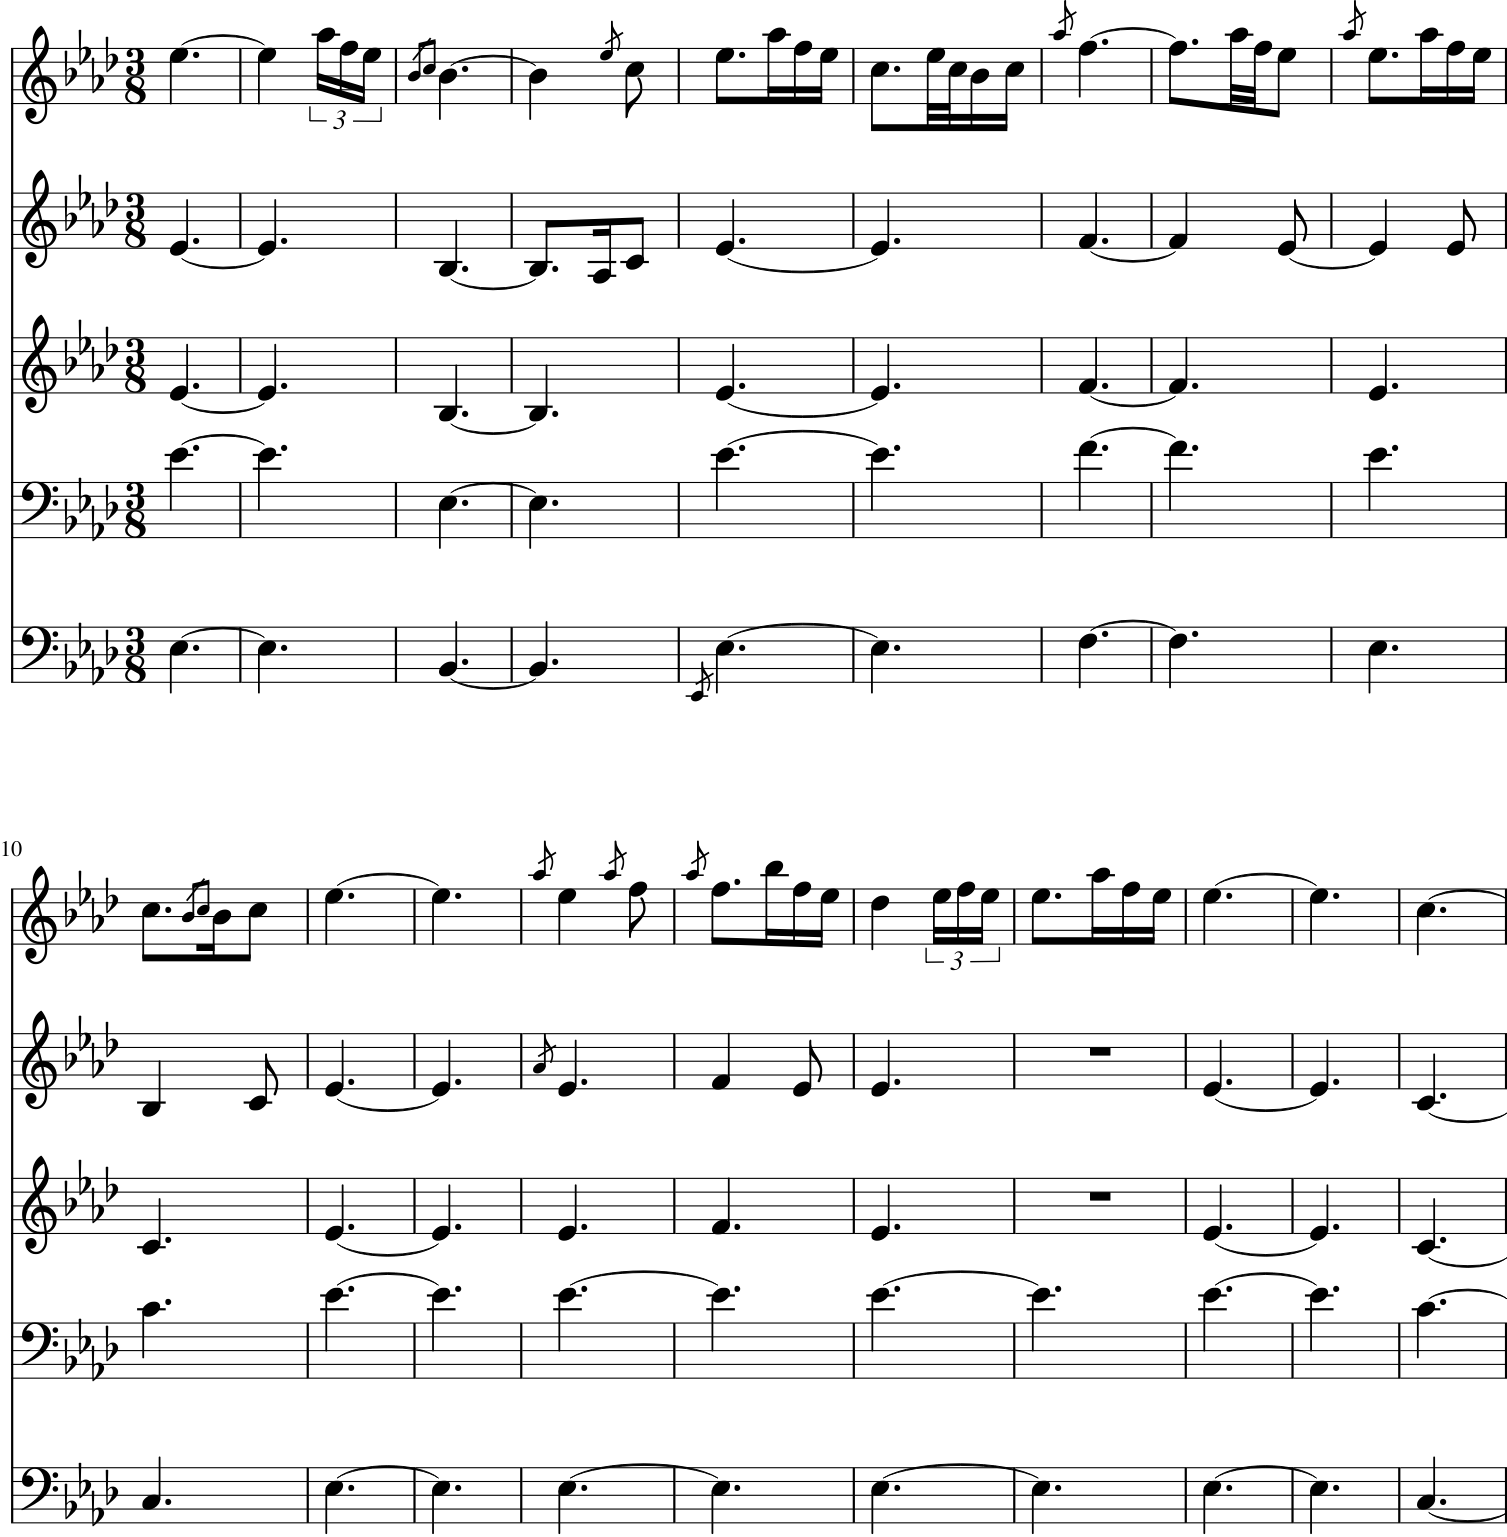

In [17]:
score.show()

In [18]:
score.write('musicxml', fp='CHP_scoreCPH_from_1_0308-1209_gen.musicxml')

PosixPath('/home/teo/userdata/SejongMusic/CHP_scoreCPH_from_1_0308-1209_gen.musicxml')

In [ ]:
for tg_idx, inst in enumerate(inst_codes[1:], start=1):
  target_idx = len(inst_codes) - tg_idx - 1
  print(f"target_idx: {target_idx}, inst: {inst}")


  #
  next_dataset.result_pairs = [x for x in next_dataset.result_pairs if x[1] == 1]
  score = stream.Score(id='mainScore')
  outputs = []
  prev_generation = None
  for i in tqdm(range(len(next_dataset))):
    sample, _, _ = next_dataset[i]
    _, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx, prev_generation=prev_generation)
    if i == 0:
      sel_out = torch.cat([output[0:1]] + [get_measure_specific_output(output, i) for i in range(3,6)], dim=0)
    else:
      sel_out = get_measure_specific_output(output, 5) 
      duration = sum([note[2] for note in model.converter(sel_out)])
      num_note_on_beat = sum([1 for note in model.converter(sel_out) if note[3] % 1.5 == 0]) / len(sel_out)
      while abs(duration - 30) > 0.1 or num_note_on_beat < 0.3:
        print(f"duration error: {duration}, inst: {target_idx}, measure: {i}, num_note_on_beat: {num_note_on_beat}")
        _, output_decoded, (attention_map, output, new_out) = model.inference(sample, target_idx, prev_generation=prev_generation)
        sel_out = get_measure_specific_output(output, 5)
        duration = sum([note[2] for note in model.converter(sel_out)])
        num_note_on_beat = sum([1 for note in model.converter(sel_out) if note[3] % 1.5 == 0]) / len(sel_out)
        # assert abs(duration - 30) < 0.1, f"duration error: {duration}, inst: {target_idx}, measure: {i}"
    prev_generation = get_measure_shifted_output(output)
    outputs.append(sel_out)
  outputs.append(get_measure_specific_output(output, 6)) # add last measure
  outputs_tensor = torch.cat(outputs, dim=0)
  gen_by_insts[inst] = decoder(model.converter(outputs_tensor))
  for _ in range(target_idx+1):
    score.insert(0, copy.copy(gen_by_insts[inst]))
  
  for prev_inst in reversed(inst_codes[:tg_idx]):
    score.insert(0, gen_by_insts[prev_inst])
      
  prev_xml_path = output_dir/ f'{save_name}_seq_{inst}.musicxml'
  print(f"write {prev_xml_path}")
  score.write('musicxml', prev_xml_path)

score.write('midi', output_dir/ f'{save_name}_seq.midi')
  